In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "40X"
trainable_blocks = ["block3", "block4"]
irun = 3


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_40X-BREAKHIS-Dataset-60-10-30-VGGINet/3'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/40X/3'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1077 files belonging to 2 classes.


Found 179 files belonging to 2 classes.


Found 539 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2082 - accuracy: 0.5625

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 3s - loss: 4.0527 - accuracy: 0.6094

3/9 [=========>....................] - ETA: 8s - loss: 3.6411 - accuracy: 0.6406

4/9 [============>.................] - ETA: 6s - loss: 3.7570 - accuracy: 0.6348

5/9 [===============>..............] - ETA: 6s - loss: 3.2836 - accuracy: 0.6828

6/9 [===================>..........] - ETA: 4s - loss: 3.0489 - accuracy: 0.7109

7/9 [======================>.......] - ETA: 2s - loss: 2.9491 - accuracy: 0.7221

8/9 [=========================>....] - ETA: 1s - loss: 2.8939 - accuracy: 0.7324

9/9 [==============================] - ETA: 0s - loss: 2.8793 - accuracy: 0.7372

9/9 [==============================] - 24s 3s/step - loss: 2.8793 - accuracy: 0.7372 - val_loss: 4.3496 - val_accuracy: 0.8659


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8106 - accuracy: 0.8203

2/9 [=====>........................] - ETA: 12s - loss: 2.2953 - accuracy: 0.7812

3/9 [=========>....................] - ETA: 9s - loss: 2.1175 - accuracy: 0.8125 

4/9 [============>.................] - ETA: 9s - loss: 2.1227 - accuracy: 0.8184

5/9 [===============>..............] - ETA: 7s - loss: 2.0905 - accuracy: 0.8234

6/9 [===================>..........] - ETA: 5s - loss: 2.0712 - accuracy: 0.8268

7/9 [======================>.......] - ETA: 3s - loss: 1.9790 - accuracy: 0.8337

8/9 [=========================>....] - ETA: 1s - loss: 1.9220 - accuracy: 0.8359

9/9 [==============================] - ETA: 0s - loss: 1.8540 - accuracy: 0.8394

9/9 [==============================] - 16s 2s/step - loss: 1.8540 - accuracy: 0.8394 - val_loss: 4.6000 - val_accuracy: 0.8547


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6406 - accuracy: 0.8594

2/9 [=====>........................] - ETA: 4s - loss: 1.5945 - accuracy: 0.8789

3/9 [=========>....................] - ETA: 9s - loss: 1.4256 - accuracy: 0.8880

4/9 [============>.................] - ETA: 9s - loss: 1.4085 - accuracy: 0.8789

5/9 [===============>..............] - ETA: 7s - loss: 1.4665 - accuracy: 0.8687

6/9 [===================>..........] - ETA: 5s - loss: 1.6022 - accuracy: 0.8581

7/9 [======================>.......] - ETA: 3s - loss: 1.5079 - accuracy: 0.8605

8/9 [=========================>....] - ETA: 1s - loss: 1.5561 - accuracy: 0.8584

9/9 [==============================] - ETA: 0s - loss: 1.5239 - accuracy: 0.8607

9/9 [==============================] - 16s 2s/step - loss: 1.5239 - accuracy: 0.8607 - val_loss: 11.8458 - val_accuracy: 0.7654


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 2.0399 - accuracy: 0.8516

2/9 [=====>........................] - ETA: 13s - loss: 1.5520 - accuracy: 0.8594

3/9 [=========>....................] - ETA: 9s - loss: 1.7565 - accuracy: 0.8490 

4/9 [============>.................] - ETA: 9s - loss: 1.7061 - accuracy: 0.8496

5/9 [===============>..............] - ETA: 7s - loss: 1.7598 - accuracy: 0.8359

6/9 [===================>..........] - ETA: 5s - loss: 1.6762 - accuracy: 0.8385

7/9 [======================>.......] - ETA: 3s - loss: 1.7173 - accuracy: 0.8438

8/9 [=========================>....] - ETA: 1s - loss: 1.8929 - accuracy: 0.8369

9/9 [==============================] - ETA: 0s - loss: 1.8207 - accuracy: 0.8431

9/9 [==============================] - 16s 2s/step - loss: 1.8207 - accuracy: 0.8431 - val_loss: 6.1662 - val_accuracy: 0.7821


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 2.2476 - accuracy: 0.8828

2/9 [=====>........................] - ETA: 13s - loss: 2.2740 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 9s - loss: 2.6075 - accuracy: 0.8542 

4/9 [============>.................] - ETA: 9s - loss: 2.6026 - accuracy: 0.8613

5/9 [===============>..............] - ETA: 7s - loss: 2.4378 - accuracy: 0.8703

6/9 [===================>..........] - ETA: 5s - loss: 2.1346 - accuracy: 0.8802

7/9 [======================>.......] - ETA: 3s - loss: 2.0837 - accuracy: 0.8795

8/9 [=========================>....] - ETA: 1s - loss: 2.0769 - accuracy: 0.8740

9/9 [==============================] - ETA: 0s - loss: 2.1751 - accuracy: 0.8635

9/9 [==============================] - 16s 2s/step - loss: 2.1751 - accuracy: 0.8635 - val_loss: 3.6707 - val_accuracy: 0.9106


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7695 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 12s - loss: 1.0347 - accuracy: 0.9023

3/9 [=========>....................] - ETA: 9s - loss: 1.2010 - accuracy: 0.9062 

4/9 [============>.................] - ETA: 9s - loss: 1.3256 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 6s - loss: 1.4519 - accuracy: 0.9047

6/9 [===================>..........] - ETA: 4s - loss: 1.4672 - accuracy: 0.9036

7/9 [======================>.......] - ETA: 3s - loss: 1.4108 - accuracy: 0.9062

8/9 [=========================>....] - ETA: 1s - loss: 1.4688 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 1.4710 - accuracy: 0.9025

9/9 [==============================] - 15s 2s/step - loss: 1.4710 - accuracy: 0.9025 - val_loss: 2.4895 - val_accuracy: 0.8715


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5346 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.6003 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.8917 - accuracy: 0.9193 

4/9 [============>.................] - ETA: 9s - loss: 0.8306 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 6s - loss: 0.8855 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 4s - loss: 0.8684 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 3s - loss: 0.8637 - accuracy: 0.9263

8/9 [=========================>....] - ETA: 1s - loss: 0.9160 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.9248

9/9 [==============================] - 15s 2s/step - loss: 0.8925 - accuracy: 0.9248 - val_loss: 4.7393 - val_accuracy: 0.8715


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0436 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 12s - loss: 1.1845 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 9s - loss: 1.0963 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 1.0832 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 7s - loss: 1.0512 - accuracy: 0.9312

6/9 [===================>..........] - ETA: 5s - loss: 1.0285 - accuracy: 0.9284

7/9 [======================>.......] - ETA: 3s - loss: 0.9525 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 0.9486 - accuracy: 0.9277

9/9 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.9304

9/9 [==============================] - 16s 2s/step - loss: 0.9178 - accuracy: 0.9304 - val_loss: 1.9783 - val_accuracy: 0.9162


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8173 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.6365 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.5106 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.6078 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.5757 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.5261 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.5585 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.5610 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.9499

9/9 [==============================] - 16s 2s/step - loss: 0.5459 - accuracy: 0.9499 - val_loss: 1.7611 - val_accuracy: 0.9274


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8018 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.9909 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 9s - loss: 0.9730 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 9s - loss: 0.9518 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.8989 - accuracy: 0.9312

6/9 [===================>..........] - ETA: 5s - loss: 0.8298 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.9294 - accuracy: 0.9308

8/9 [=========================>....] - ETA: 1s - loss: 1.0008 - accuracy: 0.9258

9/9 [==============================] - ETA: 0s - loss: 0.9696 - accuracy: 0.9276

9/9 [==============================] - 16s 2s/step - loss: 0.9696 - accuracy: 0.9276 - val_loss: 2.1371 - val_accuracy: 0.8883


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9998 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 1.1528 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.9214 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.9907 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 6s - loss: 0.9789 - accuracy: 0.9266

6/9 [===================>..........] - ETA: 4s - loss: 1.0031 - accuracy: 0.9219

7/9 [======================>.......] - ETA: 3s - loss: 0.9816 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.8720 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.9294

9/9 [==============================] - 15s 2s/step - loss: 0.8606 - accuracy: 0.9294 - val_loss: 2.2679 - val_accuracy: 0.8939


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0141 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.8595 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 9s - loss: 0.8452 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.7066 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 6s - loss: 0.5843 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 4s - loss: 0.5181 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.4995 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.4715 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.9471

9/9 [==============================] - 15s 2s/step - loss: 0.4696 - accuracy: 0.9471 - val_loss: 1.3775 - val_accuracy: 0.9218


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4892 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 12s - loss: 0.3858 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.4328 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.3904 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 6s - loss: 0.3980 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.5383 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 2s - loss: 0.5172 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4642 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.9610

9/9 [==============================] - 15s 2s/step - loss: 0.4968 - accuracy: 0.9610 - val_loss: 1.4602 - val_accuracy: 0.9274


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3519 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4455 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 15s - loss: 0.4406 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.4626 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6130 - accuracy: 0.9516 

6/9 [===================>..........] - ETA: 5s - loss: 0.7159 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.7400 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.6998 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.9499

9/9 [==============================] - 16s 2s/step - loss: 0.7169 - accuracy: 0.9499 - val_loss: 0.8454 - val_accuracy: 0.9106


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 12s - loss: 0.4830 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 13s - loss: 0.5753 - accuracy: 0.9427

4/9 [============>.................] - ETA: 13s - loss: 0.5501 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 9s - loss: 0.8585 - accuracy: 0.9203 

6/9 [===================>..........] - ETA: 6s - loss: 0.7491 - accuracy: 0.9297

7/9 [======================>.......] - ETA: 3s - loss: 0.6824 - accuracy: 0.9330

8/9 [=========================>....] - ETA: 1s - loss: 0.6537 - accuracy: 0.9326

9/9 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.9304

9/9 [==============================] - 18s 2s/step - loss: 0.7110 - accuracy: 0.9304 - val_loss: 1.1253 - val_accuracy: 0.9385


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6120 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 13s - loss: 0.5237 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 15s - loss: 0.4262 - accuracy: 0.9661

4/9 [============>.................] - ETA: 13s - loss: 0.5126 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 9s - loss: 0.9227 - accuracy: 0.9500 

6/9 [===================>..........] - ETA: 6s - loss: 0.8668 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 4s - loss: 0.8962 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.8147 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.7998 - accuracy: 0.9443

9/9 [==============================] - 19s 2s/step - loss: 0.7998 - accuracy: 0.9443 - val_loss: 1.0216 - val_accuracy: 0.9441


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6481 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 12s - loss: 1.0015 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 14s - loss: 1.0749 - accuracy: 0.9036

4/9 [============>.................] - ETA: 10s - loss: 0.9479 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 7s - loss: 0.7747 - accuracy: 0.9234 

6/9 [===================>..........] - ETA: 5s - loss: 0.6651 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.6046 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.9404

9/9 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.9369

9/9 [==============================] - 16s 2s/step - loss: 0.7442 - accuracy: 0.9369 - val_loss: 1.6609 - val_accuracy: 0.9162


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4160 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.9687 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.7187 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 9s - loss: 0.6105 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6511 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.7438 - accuracy: 0.9498

8/9 [=========================>....] - ETA: 1s - loss: 0.9058 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.9387

9/9 [==============================] - 16s 2s/step - loss: 0.8951 - accuracy: 0.9387 - val_loss: 1.5513 - val_accuracy: 0.9385


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2523 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.4153 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 14s - loss: 0.5271 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.5783 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.6122 - accuracy: 0.9578 

6/9 [===================>..........] - ETA: 5s - loss: 0.7501 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.7557 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.6980 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.9545

9/9 [==============================] - 16s 2s/step - loss: 0.6903 - accuracy: 0.9545 - val_loss: 2.2906 - val_accuracy: 0.9330


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5569 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 1.0257 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.8835 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 9s - loss: 0.8352 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 6s - loss: 0.6888 - accuracy: 0.9594

6/9 [===================>..........] - ETA: 4s - loss: 0.6569 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.6767 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6716 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.9526

9/9 [==============================] - 15s 2s/step - loss: 0.6958 - accuracy: 0.9526 - val_loss: 1.7848 - val_accuracy: 0.9385


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1657 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.1305 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 15s - loss: 0.1638 - accuracy: 0.9740

4/9 [============>.................] - ETA: 11s - loss: 0.1953 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3249 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.3545 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.3546 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4007 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.9656

9/9 [==============================] - 16s 2s/step - loss: 0.3933 - accuracy: 0.9656 - val_loss: 1.7156 - val_accuracy: 0.9441


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2965 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.5590 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.6499 - accuracy: 0.9583 

4/9 [============>.................] - ETA: 9s - loss: 0.6189 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 6s - loss: 0.6427 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.6101 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5506 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.5891 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.9517

9/9 [==============================] - 15s 2s/step - loss: 0.5898 - accuracy: 0.9517 - val_loss: 2.7179 - val_accuracy: 0.9385


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4965 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.4317 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4503 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 10s - loss: 0.6517 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.7138 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6996 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6405 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6072 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.9536

9/9 [==============================] - 16s 2s/step - loss: 0.6029 - accuracy: 0.9536 - val_loss: 3.3365 - val_accuracy: 0.9218


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9447 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.7197 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 9s - loss: 0.6862 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.7223 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.8145 - accuracy: 0.9422

6/9 [===================>..........] - ETA: 4s - loss: 0.6846 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6574 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6041 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.9582

9/9 [==============================] - 15s 2s/step - loss: 0.6343 - accuracy: 0.9582 - val_loss: 2.2243 - val_accuracy: 0.9330


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2664 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3890 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 15s - loss: 0.6021 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.6233 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.5996 - accuracy: 0.9500 

6/9 [===================>..........] - ETA: 5s - loss: 0.6229 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.6051 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5581 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.9573

9/9 [==============================] - 16s 2s/step - loss: 0.5307 - accuracy: 0.9573 - val_loss: 1.7714 - val_accuracy: 0.9274


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4213 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.3368 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 4s - loss: 0.3984 - accuracy: 0.9609

4/9 [============>.................] - ETA: 6s - loss: 0.4233 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 5s - loss: 0.5517 - accuracy: 0.9500

6/9 [===================>..........] - ETA: 3s - loss: 0.6013 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 2s - loss: 0.5236 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.4923 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.9582

9/9 [==============================] - 13s 1s/step - loss: 0.4694 - accuracy: 0.9582 - val_loss: 3.2348 - val_accuracy: 0.9050


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0675 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.3628 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.5570 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.6530 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.6820 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.7108 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.6881 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.9638

9/9 [==============================] - 16s 2s/step - loss: 0.6836 - accuracy: 0.9638 - val_loss: 1.6014 - val_accuracy: 0.9441


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3894 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.4088 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.4867 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.3864 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3857 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 4s - loss: 0.4808 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4824 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4667 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.9638

9/9 [==============================] - 15s 2s/step - loss: 0.4814 - accuracy: 0.9638 - val_loss: 1.4888 - val_accuracy: 0.9385


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1089 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.1135 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2502 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.2015 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3033 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.3668 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.3503 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3393 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.9731

9/9 [==============================] - 16s 2s/step - loss: 0.3910 - accuracy: 0.9731 - val_loss: 3.4059 - val_accuracy: 0.9050


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2598 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3121 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3665 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.3596 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3523 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.3783 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3325 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3064 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9731

9/9 [==============================] - 15s 2s/step - loss: 0.2945 - accuracy: 0.9731 - val_loss: 1.7692 - val_accuracy: 0.9218


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8291 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.8009 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.5756 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 9s - loss: 0.4548 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4485 - accuracy: 0.9641

6/9 [===================>..........] - ETA: 4s - loss: 0.4303 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.3722 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3695 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.9703

9/9 [==============================] - 15s 2s/step - loss: 0.3513 - accuracy: 0.9703 - val_loss: 1.8620 - val_accuracy: 0.9497


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0496 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.7139 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.7107 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 10s - loss: 0.6367 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.5670 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.5418 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.5637 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.5258 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.9684

9/9 [==============================] - 16s 2s/step - loss: 0.5175 - accuracy: 0.9684 - val_loss: 1.5899 - val_accuracy: 0.9385


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1013 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1966 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.1981 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.1609 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2392 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2386 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2576 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9768

9/9 [==============================] - 16s 2s/step - loss: 0.2798 - accuracy: 0.9768 - val_loss: 1.2512 - val_accuracy: 0.9385


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3521 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.3414 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 11s - loss: 0.2279 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2598 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2550 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2891 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3183 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2785 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.9796

9/9 [==============================] - 16s 2s/step - loss: 0.3010 - accuracy: 0.9796 - val_loss: 1.4393 - val_accuracy: 0.9385


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.3277 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3216 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3483 - accuracy: 0.9766 

5/9 [===============>..............] - ETA: 7s - loss: 0.2920 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2770 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2590 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3137 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.3426 - accuracy: 0.9786 - val_loss: 1.4028 - val_accuracy: 0.9441


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2276 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.4012 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.3044 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.3126 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2738 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.2838 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2902 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2619 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.9786

9/9 [==============================] - 15s 2s/step - loss: 0.2778 - accuracy: 0.9786 - val_loss: 1.2895 - val_accuracy: 0.9162


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2252 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1423 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3743 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.5234 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 7s - loss: 0.4988 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 4s - loss: 0.4309 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.3704 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3457 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.9721

9/9 [==============================] - 15s 2s/step - loss: 0.3403 - accuracy: 0.9721 - val_loss: 1.4696 - val_accuracy: 0.9162


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1821 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2048 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2825 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2894 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2672 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2539 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2559 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2873 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.9740

9/9 [==============================] - 16s 2s/step - loss: 0.3108 - accuracy: 0.9740 - val_loss: 1.1611 - val_accuracy: 0.9441


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3269 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5123 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.4690 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.3712 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.4728 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.4206 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3667 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3924 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.9777

9/9 [==============================] - 15s 2s/step - loss: 0.3852 - accuracy: 0.9777 - val_loss: 1.5231 - val_accuracy: 0.9553


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7233 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.6612 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.5181 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.4125 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3874 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.3235 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3293 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3941 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.9666

9/9 [==============================] - 16s 2s/step - loss: 0.4026 - accuracy: 0.9666 - val_loss: 1.2214 - val_accuracy: 0.9497


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4087 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4201 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.5213 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 9s - loss: 0.4573 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4375 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.4054 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.4400 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4871 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.4631 - accuracy: 0.9749 - val_loss: 1.5811 - val_accuracy: 0.9441


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1536 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.4511 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.4935 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 7s - loss: 0.4975 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 6s - loss: 0.4668 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 5s - loss: 0.4455 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4650 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4227 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.9749

9/9 [==============================] - 16s 2s/step - loss: 0.4020 - accuracy: 0.9749 - val_loss: 1.5230 - val_accuracy: 0.9330


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2970 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.7223 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.7432 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.6974 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6428 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 5s - loss: 0.7039 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.7579 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.6752 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.9564

9/9 [==============================] - 15s 2s/step - loss: 0.6420 - accuracy: 0.9564 - val_loss: 3.5857 - val_accuracy: 0.8994


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3895 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5149 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.5887 - accuracy: 0.9714 

4/9 [============>.................] - ETA: 9s - loss: 0.6990 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 6s - loss: 0.5676 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 4s - loss: 0.5626 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 2s - loss: 0.5333 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.5217 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.9740

9/9 [==============================] - 15s 2s/step - loss: 0.5191 - accuracy: 0.9740 - val_loss: 1.6054 - val_accuracy: 0.9385


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0951 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.1563 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3944 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.5135 - accuracy: 0.9648

5/9 [===============>..............] - ETA: 6s - loss: 0.6197 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 4s - loss: 0.6476 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.6209 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.6542 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.9629

9/9 [==============================] - 15s 2s/step - loss: 0.6247 - accuracy: 0.9629 - val_loss: 1.3460 - val_accuracy: 0.9330


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1872 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2451 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.2751 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3142 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.3044 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3483 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3613 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.9786

9/9 [==============================] - 16s 2s/step - loss: 0.3653 - accuracy: 0.9786 - val_loss: 1.4870 - val_accuracy: 0.9385


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6430 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4595 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 16s - loss: 0.5870 - accuracy: 0.9688

4/9 [============>.................] - ETA: 11s - loss: 0.4404 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 8s - loss: 0.4063 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.4219 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3816 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4039 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.9749

9/9 [==============================] - 17s 2s/step - loss: 0.3840 - accuracy: 0.9749 - val_loss: 1.2558 - val_accuracy: 0.9497


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3573 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.2285 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.1626 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.1489 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1469 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.1902 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1860 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1627 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1642 - accuracy: 0.9861 - val_loss: 1.6164 - val_accuracy: 0.9385


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 9.1285e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.0787 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.0909 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 7s - loss: 0.2416 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2067 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2035 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1927 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1833 - accuracy: 0.9861 - val_loss: 0.6304 - val_accuracy: 0.9553


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3353 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4160 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3387 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 10s - loss: 0.2540 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2527 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2396 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2556 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2379 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9814

9/9 [==============================] - 16s 2s/step - loss: 0.2262 - accuracy: 0.9814 - val_loss: 0.9873 - val_accuracy: 0.9553


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5429e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.0387 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.0264 - accuracy: 0.9974 

4/9 [============>.................] - ETA: 9s - loss: 0.0591 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1115 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 5s - loss: 0.1076 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1300 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1137 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.1081 - accuracy: 0.9898 - val_loss: 1.1907 - val_accuracy: 0.9497


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1584 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.4648 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.5225 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.3919 - accuracy: 0.9824 

5/9 [===============>..............] - ETA: 7s - loss: 0.3567 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 4s - loss: 0.3307 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2865 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.3088 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.9842

9/9 [==============================] - 15s 2s/step - loss: 0.2936 - accuracy: 0.9842 - val_loss: 2.0413 - val_accuracy: 0.9330


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1598 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.2179 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.2445 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.2539 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2107 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2495 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2486 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2311 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2421 - accuracy: 0.9861 - val_loss: 2.4334 - val_accuracy: 0.9385


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 8s - loss: 0.1873 - accuracy: 0.9948

4/9 [============>.................] - ETA: 6s - loss: 0.1557 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1693 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1791 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1566 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1850 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9879

9/9 [==============================] - 15s 2s/step - loss: 0.1759 - accuracy: 0.9879 - val_loss: 1.8652 - val_accuracy: 0.9609


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 5.5394e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.0379 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.0959 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.0964 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1120 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 5s - loss: 0.1115 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1030 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1220 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1160 - accuracy: 0.9879 - val_loss: 1.5023 - val_accuracy: 0.9553


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8858 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 15s - loss: 0.4637 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 16s - loss: 0.3310 - accuracy: 0.9792

4/9 [============>.................] - ETA: 11s - loss: 0.2721 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2543 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2234 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2071 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2144 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9814

9/9 [==============================] - 17s 2s/step - loss: 0.2256 - accuracy: 0.9814 - val_loss: 1.1072 - val_accuracy: 0.9553


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0055 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0037 - accuracy: 0.9974

4/9 [============>.................] - ETA: 9s - loss: 0.0028 - accuracy: 0.9980 

5/9 [===============>..............] - ETA: 7s - loss: 0.0024 - accuracy: 0.9984

6/9 [===================>..........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9961

7/9 [======================>.......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.0905 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9907

9/9 [==============================] - 16s 2s/step - loss: 0.0861 - accuracy: 0.9907 - val_loss: 2.2631 - val_accuracy: 0.9441


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 6.2780e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1152 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 15s - loss: 0.1389 - accuracy: 0.9818

4/9 [============>.................] - ETA: 12s - loss: 0.2160 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 9s - loss: 0.2227 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 6s - loss: 0.2218 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 4s - loss: 0.2072 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2228 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9805

9/9 [==============================] - 19s 2s/step - loss: 0.2119 - accuracy: 0.9805 - val_loss: 1.1714 - val_accuracy: 0.9609


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.5815 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.4378 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.4021 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3366 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3247 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3057 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.9851

9/9 [==============================] - 15s 2s/step - loss: 0.2906 - accuracy: 0.9851 - val_loss: 1.1502 - val_accuracy: 0.9609


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1110 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1480 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1180 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.1264 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.1889 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2102 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2298 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9833

9/9 [==============================] - 15s 2s/step - loss: 0.2635 - accuracy: 0.9833 - val_loss: 1.7977 - val_accuracy: 0.9441


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1453 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1437 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3891 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3531 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4527 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4418 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4045 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3825 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.9777

9/9 [==============================] - 16s 2s/step - loss: 0.3637 - accuracy: 0.9777 - val_loss: 1.6151 - val_accuracy: 0.9609


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 4.4889e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.2188 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 15s - loss: 0.1559 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1169 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1318 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1743 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1575 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2006 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1908 - accuracy: 0.9861 - val_loss: 1.5172 - val_accuracy: 0.9609


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2201 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2018 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.4063 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3686 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.4140 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 4s - loss: 0.3589 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3138 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3302 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3723 - accuracy: 0.9777

9/9 [==============================] - 15s 2s/step - loss: 0.3723 - accuracy: 0.9777 - val_loss: 1.5535 - val_accuracy: 0.9553


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0708 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.1594 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.1275 - accuracy: 0.9870

4/9 [============>.................] - ETA: 9s - loss: 0.3143 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2765 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 4s - loss: 0.3918 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3659 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3204 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.9786

9/9 [==============================] - 15s 2s/step - loss: 0.3046 - accuracy: 0.9786 - val_loss: 1.6126 - val_accuracy: 0.9497


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2608 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.5488 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 3s - loss: 0.3979 - accuracy: 0.9688

4/9 [============>.................] - ETA: 5s - loss: 0.3416 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 4s - loss: 0.3870 - accuracy: 0.9734

6/9 [===================>..........] - ETA: 3s - loss: 0.3616 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 2s - loss: 0.3238 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3452 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.9768

9/9 [==============================] - 12s 1s/step - loss: 0.3484 - accuracy: 0.9768 - val_loss: 1.2989 - val_accuracy: 0.9553


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2710 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1355 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1140 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.1427 - accuracy: 0.9883 

5/9 [===============>..............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1269 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1472 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1306 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1757 - accuracy: 0.9879 - val_loss: 1.8927 - val_accuracy: 0.9609


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 5.2433e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1833 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.1222 - accuracy: 0.9974 

4/9 [============>.................] - ETA: 9s - loss: 0.1649 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 6s - loss: 0.2599 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.2167 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2547 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9898

9/9 [==============================] - 15s 2s/step - loss: 0.2483 - accuracy: 0.9898 - val_loss: 2.3261 - val_accuracy: 0.9553


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0669 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0820 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.0888 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.1092 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1714 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 4s - loss: 0.1801 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1675 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1466 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9898

9/9 [==============================] - 15s 2s/step - loss: 0.1394 - accuracy: 0.9898 - val_loss: 2.2000 - val_accuracy: 0.9553


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 16s - loss: 0.2528 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 11s - loss: 0.2673 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2308 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1971 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1900 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1629 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1501 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1470 - accuracy: 0.9861 - val_loss: 3.3633 - val_accuracy: 0.9218


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 4.4076e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0022 - accuracy: 1.0000   

3/9 [=========>....................] - ETA: 15s - loss: 0.0751 - accuracy: 0.9974

4/9 [============>.................] - ETA: 10s - loss: 0.1032 - accuracy: 0.9961

5/9 [===============>..............] - ETA: 7s - loss: 0.1263 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1411 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1582 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1394 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.1378 - accuracy: 0.9879 - val_loss: 5.0573 - val_accuracy: 0.8883


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1842 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.1063 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2472 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2162 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.2091 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.1743 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1529 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1370 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.1303 - accuracy: 0.9861 - val_loss: 2.0214 - val_accuracy: 0.9609


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6485 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.4282 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3050 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.3745 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.3377 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.2815 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2413 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2260 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9805

9/9 [==============================] - 17s 2s/step - loss: 0.2415 - accuracy: 0.9805 - val_loss: 1.5947 - val_accuracy: 0.9609


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2450 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2431 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1897 - accuracy: 0.9922 

4/9 [============>.................] - ETA: 9s - loss: 0.1980 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1942 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1757 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1541 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1591 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.1735 - accuracy: 0.9889 - val_loss: 0.8922 - val_accuracy: 0.9609


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1444 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.4116 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 3s - loss: 0.2744 - accuracy: 0.9870

4/9 [============>.................] - ETA: 6s - loss: 0.2312 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 4s - loss: 0.1888 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 3s - loss: 0.1625 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 2s - loss: 0.1479 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1388 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9879

9/9 [==============================] - 12s 1s/step - loss: 0.1377 - accuracy: 0.9879 - val_loss: 1.3459 - val_accuracy: 0.9553


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 3.0827e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 1.8886e-05 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 3s - loss: 2.5122e-05 - accuracy: 1.0000

4/9 [============>.................] - ETA: 5s - loss: 0.0391 - accuracy: 0.9941    

5/9 [===============>..............] - ETA: 5s - loss: 0.0973 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 3s - loss: 0.0811 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 2s - loss: 0.2059 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2448 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9861

9/9 [==============================] - 13s 1s/step - loss: 0.2327 - accuracy: 0.9861 - val_loss: 1.3688 - val_accuracy: 0.9441


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3089 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1665 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.1350 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 9s - loss: 0.1449 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1335 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 5s - loss: 0.1694 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1859 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1633 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.1944 - accuracy: 0.9851 - val_loss: 1.1425 - val_accuracy: 0.9609


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2306 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1570 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1047 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0803 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.2913 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.3264 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.3016 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.3304 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.3538 - accuracy: 0.9851 - val_loss: 0.7267 - val_accuracy: 0.9609


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3222 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.1814 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 3s - loss: 0.3450 - accuracy: 0.9844

4/9 [============>.................] - ETA: 5s - loss: 0.3422 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 5s - loss: 0.2768 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 3s - loss: 0.2341 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.2007 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1928 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9898

9/9 [==============================] - 13s 1s/step - loss: 0.1833 - accuracy: 0.9898 - val_loss: 0.6293 - val_accuracy: 0.9665


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1672 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2561 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2314 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.1736 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 7s - loss: 0.1632 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.2469 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.3678 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3218 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.9833

9/9 [==============================] - 16s 2s/step - loss: 0.3069 - accuracy: 0.9833 - val_loss: 1.3076 - val_accuracy: 0.9553


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2890 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.3860 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.3010 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3317 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3468 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3639 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3342 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.9805

9/9 [==============================] - 16s 2s/step - loss: 0.3178 - accuracy: 0.9805 - val_loss: 1.8140 - val_accuracy: 0.9609


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 6.5193e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 10s - loss: 0.0985 - accuracy: 0.9922

4/9 [============>.................] - ETA: 9s - loss: 0.0832 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.0823 - accuracy: 0.9875

6/9 [===================>..........] - ETA: 4s - loss: 0.0904 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.0896 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1791 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9870

9/9 [==============================] - 15s 2s/step - loss: 0.1723 - accuracy: 0.9870 - val_loss: 2.0173 - val_accuracy: 0.9553


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4554 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.4254 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 3s - loss: 0.3857 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3045 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 5s - loss: 0.3003 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 3s - loss: 0.3184 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 2s - loss: 0.2880 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2569 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.9824

9/9 [==============================] - 13s 1s/step - loss: 0.2482 - accuracy: 0.9824 - val_loss: 0.7394 - val_accuracy: 0.9665


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.0789 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 3s - loss: 0.1040 - accuracy: 0.9896

4/9 [============>.................] - ETA: 5s - loss: 0.0782 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 4s - loss: 0.1480 - accuracy: 0.9891

6/9 [===================>..........] - ETA: 3s - loss: 0.1233 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 2s - loss: 0.1584 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1600 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9898

9/9 [==============================] - 12s 1s/step - loss: 0.1521 - accuracy: 0.9898 - val_loss: 0.7499 - val_accuracy: 0.9665


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 5.6984e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 16s - loss: 0.2189 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 11s - loss: 0.3812 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3565 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 8s - loss: 0.2882 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2914 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2836 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2482 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9842

9/9 [==============================] - 17s 2s/step - loss: 0.2420 - accuracy: 0.9842 - val_loss: 0.8533 - val_accuracy: 0.9777


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 16s - loss: 0.0494 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 15s - loss: 0.0795 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0977 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.0781 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0819 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.0940 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9935

9/9 [==============================] - 16s 2s/step - loss: 0.0894 - accuracy: 0.9935 - val_loss: 2.2323 - val_accuracy: 0.9553


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7719 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3860 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.3012 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.2448 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2924 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2437 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2549 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2230 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9851

9/9 [==============================] - 16s 2s/step - loss: 0.2294 - accuracy: 0.9851 - val_loss: 1.9660 - val_accuracy: 0.9553


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1302 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.1173 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 9s - loss: 0.1906 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1432 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 6s - loss: 0.1203 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.2524 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2163 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1893 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9870

9/9 [==============================] - 15s 2s/step - loss: 0.2714 - accuracy: 0.9870 - val_loss: 2.2079 - val_accuracy: 0.9553


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.0142 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 9s - loss: 0.0645 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 10s - loss: 0.0484 - accuracy: 0.9961

5/9 [===============>..............] - ETA: 7s - loss: 0.1009 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1161 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1897 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1662 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9889

9/9 [==============================] - 15s 2s/step - loss: 0.1581 - accuracy: 0.9889 - val_loss: 0.4016 - val_accuracy: 0.9777


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4045 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.2304 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 3s - loss: 0.2062 - accuracy: 0.9818

4/9 [============>.................] - ETA: 5s - loss: 0.2513 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 4s - loss: 0.2012 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 3s - loss: 0.1677 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 2s - loss: 0.2290 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2483 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9861

9/9 [==============================] - 12s 1s/step - loss: 0.2361 - accuracy: 0.9861 - val_loss: 0.6712 - val_accuracy: 0.9777


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 2.8964e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.1767 - accuracy: 0.9922    

3/9 [=========>....................] - ETA: 10s - loss: 0.1961 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1507 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1253 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1045 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.2332 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2173 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9870

9/9 [==============================] - 16s 2s/step - loss: 0.2628 - accuracy: 0.9870 - val_loss: 1.4717 - val_accuracy: 0.9553


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1531 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1986 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1469 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 10s - loss: 0.1102 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.1064 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.1214 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1987 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2987 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9861

9/9 [==============================] - 16s 2s/step - loss: 0.2840 - accuracy: 0.9861 - val_loss: 2.0075 - val_accuracy: 0.9441


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0352 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0514 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.0676 - accuracy: 0.9870 

4/9 [============>.................] - ETA: 9s - loss: 0.1281 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1301 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.1084 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.1207 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1056 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9889

9/9 [==============================] - 15s 2s/step - loss: 0.1024 - accuracy: 0.9889 - val_loss: 0.8315 - val_accuracy: 0.9721


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2906 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.1453 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1662 - accuracy: 0.9896

4/9 [============>.................] - ETA: 9s - loss: 0.1246 - accuracy: 0.9922 

5/9 [===============>..............] - ETA: 7s - loss: 0.0997 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 5s - loss: 0.0832 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0725 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.0953 - accuracy: 0.9932

9/9 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9898

9/9 [==============================] - 16s 2s/step - loss: 0.1772 - accuracy: 0.9898 - val_loss: 0.5124 - val_accuracy: 0.9721


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1485 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.5743 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 11s - loss: 0.4834 - accuracy: 0.9844

4/9 [============>.................] - ETA: 9s - loss: 0.3708 - accuracy: 0.9863 

5/9 [===============>..............] - ETA: 8s - loss: 0.3242 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.2808 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2833 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.3221 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.9870

9/9 [==============================] - 17s 2s/step - loss: 0.3063 - accuracy: 0.9870 - val_loss: 1.8418 - val_accuracy: 0.9553


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2253 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1340 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1646 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2430 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2420 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2481 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2237 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2003 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9842

9/9 [==============================] - 16s 2s/step - loss: 0.1905 - accuracy: 0.9842 - val_loss: 0.9568 - val_accuracy: 0.9609


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5526 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.7289 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4859 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.3691 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 7s - loss: 0.3383 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 4s - loss: 0.3110 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2763 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2691 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9861

9/9 [==============================] - 15s 2s/step - loss: 0.2585 - accuracy: 0.9861 - val_loss: 0.3870 - val_accuracy: 0.9777


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 4.4987e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 13s - loss: 0.1782 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 9s - loss: 0.1215 - accuracy: 0.9948 

4/9 [============>.................] - ETA: 9s - loss: 0.1570 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1474 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 5s - loss: 0.1721 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.2213 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.2956 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.2811 - accuracy: 0.9889 - val_loss: 0.2844 - val_accuracy: 0.9777


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0818e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 5.4102e-05 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 10s - loss: 0.1790 - accuracy: 0.9948    

4/9 [============>.................] - ETA: 10s - loss: 0.2348 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.2074 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.2375 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.3247 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2906 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9889

9/9 [==============================] - 16s 2s/step - loss: 0.2969 - accuracy: 0.9889 - val_loss: 0.8818 - val_accuracy: 0.9721


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3124 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2112 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1408 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.2847 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2279 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1944 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1668 - accuracy: 0.9933

8/9 [=========================>....] - ETA: 1s - loss: 0.2128 - accuracy: 0.9922

9/9 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9926

9/9 [==============================] - 16s 2s/step - loss: 0.2023 - accuracy: 0.9926 - val_loss: 0.8998 - val_accuracy: 0.9721


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0561 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 15s - loss: 0.3466 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.3462 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2769 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2863 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.2806 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2608 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9879

9/9 [==============================] - 16s 2s/step - loss: 0.2560 - accuracy: 0.9879 - val_loss: 1.3371 - val_accuracy: 0.9497


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

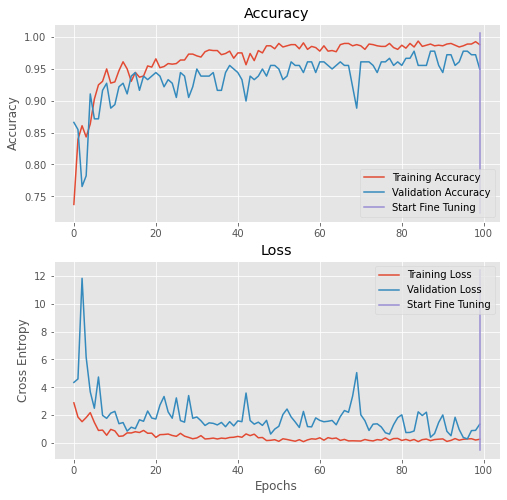

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.6353 - accuracy: 0.9688

2/5 [===========>..................] - ETA: 2s - loss: 2.2185 - accuracy: 0.9492

3/5 [=================>............] - ETA: 2s - loss: 2.4909 - accuracy: 0.9531

4/5 [=======================>......] - ETA: 1s - loss: 2.4379 - accuracy: 0.9512

5/5 [==============================] - ETA: 0s - loss: 2.3158 - accuracy: 0.9536

5/5 [==============================] - 9s 2s/step - loss: 2.3158 - accuracy: 0.9536


[2.3157777786254883, 0.9536178112030029]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

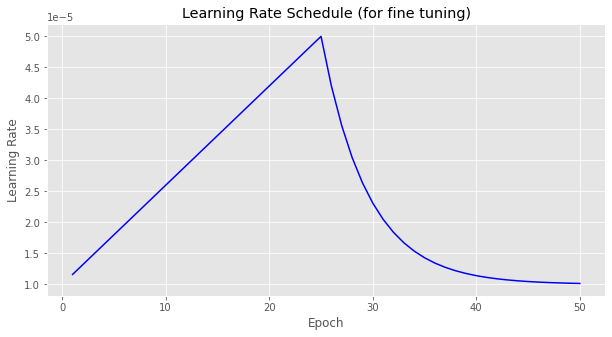

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1077 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 8.9111e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 12s - loss: 5.9923e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0078 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 11s - loss: 0.1697 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 10s - loss: 0.1424 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 9s - loss: 0.1221 - accuracy: 0.9955 

 8/17 [=============>................] - ETA: 11s - loss: 0.1414 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 9s - loss: 0.1319 - accuracy: 0.9913 

10/17 [================>.............] - ETA: 9s - loss: 0.1439 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 7s - loss: 0.1335 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 6s - loss: 0.1224 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 4s - loss: 0.1134 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1833 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1839 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2145 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9879

17/17 [==============================] - 21s 1s/step - loss: 0.2040 - accuracy: 0.9879 - val_loss: 0.9713 - val_accuracy: 0.9497



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1687 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.0993 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1729 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.1441 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1701 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1489 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.2551 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.3066 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.3264 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2992 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.3163 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.3234 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.3235 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.4395 - accuracy: 0.9805

17/17 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.9805

17/17 [==============================] - 24s 1s/step - loss: 0.4250 - accuracy: 0.9805 - val_loss: 0.7583 - val_accuracy: 0.9553



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 6.5558e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 3.2856e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0215 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.0172 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 13s - loss: 0.0319 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0326 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0482 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.0857 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.0940 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.0867 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.0805 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.0796 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.0888 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9870

17/17 [==============================] - 23s 1s/step - loss: 0.0988 - accuracy: 0.9870 - val_loss: 0.6562 - val_accuracy: 0.9665



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 9.3132e-10 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 10s - loss: 0.2102 - accuracy: 0.9792   

 4/17 [======>.......................] - ETA: 10s - loss: 0.3714 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 13s - loss: 0.4027 - accuracy: 0.9688

 6/17 [=========>....................] - ETA: 12s - loss: 0.3356 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 10s - loss: 0.4231 - accuracy: 0.9732

 8/17 [=============>................] - ETA: 11s - loss: 0.3702 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 9s - loss: 0.3291 - accuracy: 0.9792 

10/17 [================>.............] - ETA: 8s - loss: 0.3020 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 7s - loss: 0.3101 - accuracy: 0.9773

12/17 [====================>.........] - ETA: 5s - loss: 0.2844 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 4s - loss: 0.2846 - accuracy: 0.9784

14/17 [=======================>......] - ETA: 3s - loss: 0.2643 - accuracy: 0.9799

15/17 [=========================>....] - ETA: 2s - loss: 0.2550 - accuracy: 0.9802

16/17 [===========================>..] - ETA: 1s - loss: 0.2769 - accuracy: 0.9785

17/17 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.9768

17/17 [==============================] - 21s 1s/step - loss: 0.3180 - accuracy: 0.9768 - val_loss: 0.5926 - val_accuracy: 0.9721



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 1.7834 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 12s - loss: 0.9802 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 14s - loss: 0.8414 - accuracy: 0.9635

 4/17 [======>.......................] - ETA: 11s - loss: 0.6314 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 12s - loss: 0.5428 - accuracy: 0.9688

 6/17 [=========>....................] - ETA: 11s - loss: 0.4523 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 15s - loss: 0.3877 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 14s - loss: 0.3392 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 13s - loss: 0.4042 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.3718 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 9s - loss: 0.3687 - accuracy: 0.9773 

12/17 [====================>.........] - ETA: 7s - loss: 0.3380 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 5s - loss: 0.3120 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 3s - loss: 0.2897 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2704 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2535 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9851

17/17 [==============================] - 23s 1s/step - loss: 0.2410 - accuracy: 0.9851 - val_loss: 0.5366 - val_accuracy: 0.9721



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1405 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.6792 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 20s - loss: 0.7218 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 20s - loss: 0.5413 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.6624 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 15s - loss: 0.5520 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 16s - loss: 0.4732 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.4140 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.3681 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.3375 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.3069 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2814 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2597 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.3001 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2833 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2656 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9879

17/17 [==============================] - 23s 1s/step - loss: 0.2971 - accuracy: 0.9879 - val_loss: 0.5050 - val_accuracy: 0.9777



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2216 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.1108 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 12s - loss: 0.0739 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0554 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 14s - loss: 0.1728 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.1440 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 11s - loss: 0.1881 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1646 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.1464 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.1501 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1393 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1277 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1422 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1320 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1240 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1252 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.1190 - accuracy: 0.9907 - val_loss: 0.4938 - val_accuracy: 0.9832



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2581 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.1329 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.0926 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.2182 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.1784 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.1871 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 12s - loss: 0.3061 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 13s - loss: 0.2829 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 12s - loss: 0.2515 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.2263 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2058 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2341 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2161 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2769 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2584 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9861

17/17 [==============================] - 23s 1s/step - loss: 0.2304 - accuracy: 0.9861 - val_loss: 0.4922 - val_accuracy: 0.9832



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4697 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.2348 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.1566 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.1633 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.1306 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.1719 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1915 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1676 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.1490 - accuracy: 0.9931

10/17 [================>.............] - ETA: 12s - loss: 0.1344 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1222 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.1757 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1641 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1524 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1425 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1402 - accuracy: 0.9926 - val_loss: 0.4881 - val_accuracy: 0.9832



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5389 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2694 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.1797 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 11s - loss: 0.4146 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 11s - loss: 0.3317 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.2764 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.2369 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.2656 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.2361 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2125 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 8s - loss: 0.1945 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1783 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1646 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1529 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1953 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1831 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.2086 - accuracy: 0.9916 - val_loss: 0.4803 - val_accuracy: 0.9832



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 1.7045 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 7s - loss: 0.8522 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.7354 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.5515 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.5674 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 13s - loss: 0.4732 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.4056 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.3550 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.3155 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.2840 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.2582 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.2532 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.2337 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.2170 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.2195 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.2169 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.2333 - accuracy: 0.9916 - val_loss: 0.4835 - val_accuracy: 0.9777



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1021 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 14s - loss: 0.1414 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.0943 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0707 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.2965 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 18s - loss: 0.2471 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.2118 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2001 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.2732 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2781 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2528 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2306 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2322 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2167 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2365 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9861

17/17 [==============================] - 24s 1s/step - loss: 0.2249 - accuracy: 0.9861 - val_loss: 0.4980 - val_accuracy: 0.9777



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0820 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.3320 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 11s - loss: 0.2490 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.4394 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.4356 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 15s - loss: 0.4242 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.3714 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.3301 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.2971 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2900 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2684 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.3013 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.2798 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2612 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.2478 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9898

17/17 [==============================] - 23s 1s/step - loss: 0.2356 - accuracy: 0.9898 - val_loss: 0.4988 - val_accuracy: 0.9777



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1479 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.0740 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 15s - loss: 0.0493 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0370 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0296 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.1722 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1476 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1291 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.2424 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2609 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2372 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2579 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2381 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2271 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2190 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.1969 - accuracy: 0.9870 - val_loss: 0.5024 - val_accuracy: 0.9777



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1597 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.0799 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.0533 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.3033 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.2426 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.2081 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2182 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1909 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1697 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1527 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1389 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1896 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1750 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1625 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1517 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1422 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9935

17/17 [==============================] - 24s 1s/step - loss: 0.1511 - accuracy: 0.9935 - val_loss: 0.5088 - val_accuracy: 0.9777



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1442 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.0878 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 9s - loss: 0.0586 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 10s - loss: 0.0946 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 12s - loss: 0.1384 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 11s - loss: 0.1304 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 15s - loss: 0.1493 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.1307 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1161 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1048 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.0953 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1553 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1747 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1930 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1959 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1837 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9879

17/17 [==============================] - 23s 1s/step - loss: 0.1898 - accuracy: 0.9879 - val_loss: 0.5060 - val_accuracy: 0.9777



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 9.9835e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 1.2522e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 8.3486e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 6.2615e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 17s - loss: 7.8996e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 14s - loss: 6.5831e-05 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 16s - loss: 0.1249 - accuracy: 0.9933    

 8/17 [=============>................] - ETA: 15s - loss: 0.1093 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.0974 - accuracy: 0.9948

10/17 [================>.............] - ETA: 12s - loss: 0.0877 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0797 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0731 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0684 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9944

15/17 [=========================>....] - ETA: 2s - loss: 0.0601 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0564 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0536 - accuracy: 0.9954 - val_loss: 0.5112 - val_accuracy: 0.9777



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 9.3132e-10 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 5s - loss: 6.2088e-10 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 7s - loss: 0.1855 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 11s - loss: 0.1484 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 9s - loss: 0.2981 - accuracy: 0.9922 

 7/17 [===========>..................] - ETA: 11s - loss: 0.3192 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 11s - loss: 0.2793 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.2935 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.2642 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.2401 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.2543 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2596 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.2411 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2250 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2110 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9916

17/17 [==============================] - 22s 1s/step - loss: 0.2006 - accuracy: 0.9916 - val_loss: 0.5147 - val_accuracy: 0.9777



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 1.5701e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 10s - loss: 0.1128 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.0848 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 11s - loss: 0.0565 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 10s - loss: 0.0484 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 11s - loss: 0.0424 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 9s - loss: 0.0377 - accuracy: 0.9965 

10/17 [================>.............] - ETA: 8s - loss: 0.0339 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 6s - loss: 0.0308 - accuracy: 0.9972

12/17 [====================>.........] - ETA: 5s - loss: 0.0283 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 4s - loss: 0.0553 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 3s - loss: 0.0513 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.0800 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0750 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9954

17/17 [==============================] - 21s 1s/step - loss: 0.0713 - accuracy: 0.9954 - val_loss: 0.5079 - val_accuracy: 0.9777



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.0944 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.0629 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.4253 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.3403 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.2836 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2430 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.1891 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1702 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1601 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1867 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1734 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1618 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1517 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1783 - accuracy: 0.9926 - val_loss: 0.5057 - val_accuracy: 0.9777



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 4.1629e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 1.1715e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 0.0140 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.0774 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0940 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0805 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0705 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0627 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.0695 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 7s - loss: 0.0911 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.0835 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0771 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 3s - loss: 0.0836 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0780 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0939 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.1301 - accuracy: 0.9916 - val_loss: 0.5054 - val_accuracy: 0.9777



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3852 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.2811 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 5s - loss: 0.1938 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.3190 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 13s - loss: 0.3069 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 12s - loss: 0.2558 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 12s - loss: 0.2395 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 11s - loss: 0.2378 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 9s - loss: 0.2114 - accuracy: 0.9844 

10/17 [================>.............] - ETA: 8s - loss: 0.2322 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 6s - loss: 0.2427 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 5s - loss: 0.2234 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 4s - loss: 0.2062 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.1915 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1829 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1849 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9861

17/17 [==============================] - 21s 1s/step - loss: 0.1962 - accuracy: 0.9861 - val_loss: 0.4970 - val_accuracy: 0.9777



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 1.6764e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.0429e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 6.9530e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 0.2301 - accuracy: 0.9922    

 5/17 [=======>......................] - ETA: 19s - loss: 0.1842 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.1811 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1861 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.2217 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1971 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1787 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1625 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1497 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1382 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1449 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1352 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9916

17/17 [==============================] - 23s 1s/step - loss: 0.1285 - accuracy: 0.9916 - val_loss: 0.5002 - val_accuracy: 0.9777



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0265 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.0584 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.2841 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.3239 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 13s - loss: 0.2699 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.2714 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.2440 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2259 - accuracy: 0.9826

10/17 [================>.............] - ETA: 10s - loss: 0.2033 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2192 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2009 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.1855 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2576 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2667 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2705 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9824

17/17 [==============================] - 23s 1s/step - loss: 0.2572 - accuracy: 0.9824 - val_loss: 0.5032 - val_accuracy: 0.9777



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 7.3584e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 19s - loss: 0.0229 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9978

 8/17 [=============>................] - ETA: 12s - loss: 0.0118 - accuracy: 0.9980

 9/17 [==============>...............] - ETA: 11s - loss: 0.0105 - accuracy: 0.9983

10/17 [================>.............] - ETA: 10s - loss: 0.0095 - accuracy: 0.9984

11/17 [==================>...........] - ETA: 9s - loss: 0.1157 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1060 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1141 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1140 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1359 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1325 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9889

17/17 [==============================] - 23s 1s/step - loss: 0.1413 - accuracy: 0.9889 - val_loss: 0.5076 - val_accuracy: 0.9777



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 6.6721e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 3.3366e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.0060 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 22s - loss: 0.1769 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1185 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1053 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.0948 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1033 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.0947 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1171 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1359 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1366 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1523 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9870

17/17 [==============================] - 24s 1s/step - loss: 0.1512 - accuracy: 0.9870 - val_loss: 0.5029 - val_accuracy: 0.9777



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2353 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 7s - loss: 0.1177 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 7s - loss: 0.0943 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 12s - loss: 0.0718 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.0997 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 11s - loss: 0.0831 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.0712 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.0623 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 9s - loss: 0.1090 - accuracy: 0.9896 

10/17 [================>.............] - ETA: 10s - loss: 0.0981 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.0892 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1105 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1020 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1105 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1108 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1038 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9907

17/17 [==============================] - 22s 1s/step - loss: 0.0987 - accuracy: 0.9907 - val_loss: 0.5082 - val_accuracy: 0.9777



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 2.1724 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 1.0862 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.7241 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.8881 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 19s - loss: 0.7105 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.5921 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.5075 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.4441 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.3947 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.3553 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.3983 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.4016 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.3712 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.3447 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.3219 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.3018 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.9926

17/17 [==============================] - 23s 1s/step - loss: 0.2869 - accuracy: 0.9926 - val_loss: 0.5173 - val_accuracy: 0.9777



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 4.0357e-08 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 1.1185e-04 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 13s - loss: 8.9483e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 13s - loss: 4.9032e-04 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 13s - loss: 4.2059e-04 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 12s - loss: 0.1058 - accuracy: 0.9961    

 9/17 [==============>...............] - ETA: 10s - loss: 0.1012 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.1437 - accuracy: 0.9922 

11/17 [==================>...........] - ETA: 7s - loss: 0.1306 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 6s - loss: 0.1359 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1256 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1166 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1089 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1021 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.1070 - accuracy: 0.9935 - val_loss: 0.5173 - val_accuracy: 0.9777



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 1.9558e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 0.0838 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 15s - loss: 0.0679 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0452 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0388 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0339 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 12s - loss: 0.0302 - accuracy: 0.9965

10/17 [================>.............] - ETA: 11s - loss: 0.0271 - accuracy: 0.9969

11/17 [==================>...........] - ETA: 9s - loss: 0.0247 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.0499 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0461 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 4s - loss: 0.0428 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.0400 - accuracy: 0.9969

16/17 [===========================>..] - ETA: 1s - loss: 0.0475 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0451 - accuracy: 0.9954 - val_loss: 0.5188 - val_accuracy: 0.9832



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1954 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.5269 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 17s - loss: 0.4324 - accuracy: 0.9635

 4/17 [======>.......................] - ETA: 18s - loss: 0.3243 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 16s - loss: 0.4754 - accuracy: 0.9719

 6/17 [=========>....................] - ETA: 14s - loss: 0.3962 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 14s - loss: 0.3396 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 13s - loss: 0.2971 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2642 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2378 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2576 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2361 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2180 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2024 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2125 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1992 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9889

17/17 [==============================] - 24s 1s/step - loss: 0.1894 - accuracy: 0.9889 - val_loss: 0.5115 - val_accuracy: 0.9832



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.4381 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 8s - loss: 0.4144 - accuracy: 0.9740 

 4/17 [======>.......................] - ETA: 13s - loss: 0.3499 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 11s - loss: 0.2799 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 13s - loss: 0.2333 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 11s - loss: 0.2040 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 11s - loss: 0.1785 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 9s - loss: 0.1587 - accuracy: 0.9878 

10/17 [================>.............] - ETA: 9s - loss: 0.1531 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.1447 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 6s - loss: 0.1326 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1224 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1137 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1061 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0995 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9907

17/17 [==============================] - 22s 1s/step - loss: 0.0946 - accuracy: 0.9907 - val_loss: 0.5037 - val_accuracy: 0.9832



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 21s - loss: 0.2578 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 23s - loss: 0.2287 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 20s - loss: 0.1830 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 18s - loss: 0.1623 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1991 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1770 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2414 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2859 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2620 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2533 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2352 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2630 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2532 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9851

17/17 [==============================] - 24s 1s/step - loss: 0.2519 - accuracy: 0.9851 - val_loss: 0.4937 - val_accuracy: 0.9832



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 2.9706e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.2333 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.4455 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.3341 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.2914 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.2429 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.2082 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1821 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1619 - accuracy: 0.9931

10/17 [================>.............] - ETA: 9s - loss: 0.1457 - accuracy: 0.9937 

11/17 [==================>...........] - ETA: 8s - loss: 0.1512 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.1386 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1280 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 3s - loss: 0.1276 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1198 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1123 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9935

17/17 [==============================] - 23s 1s/step - loss: 0.1068 - accuracy: 0.9935 - val_loss: 0.4934 - val_accuracy: 0.9832



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 1.9185e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 9.5241e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 0.0508 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 18s - loss: 0.0474 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0510 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0728 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0624 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 10s - loss: 0.0770 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.0693 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.0630 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.0608 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0993 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.0946 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.0883 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0952 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9889

17/17 [==============================] - 23s 1s/step - loss: 0.1151 - accuracy: 0.9889 - val_loss: 0.4909 - val_accuracy: 0.9832



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7625e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 1.8242e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 20s - loss: 0.2569 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.2055 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.1907 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1431 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 13s - loss: 0.1272 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.1267 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1151 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.1056 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0974 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0905 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0844 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0832 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9954

17/17 [==============================] - 24s 1s/step - loss: 0.0791 - accuracy: 0.9954 - val_loss: 0.4951 - val_accuracy: 0.9832



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0904 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0452 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.0301 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0226 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 19s - loss: 0.1459 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1216 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1046 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1093 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.0972 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0888 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1052 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0964 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.0890 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0826 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0771 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.0756 - accuracy: 0.9916 - val_loss: 0.5018 - val_accuracy: 0.9832



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.0245 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 25s - loss: 0.1900 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 20s - loss: 0.1140 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 19s - loss: 0.2120 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.2145 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.2122 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1907 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1717 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 10s - loss: 0.1561 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 7s - loss: 0.1837 - accuracy: 0.9883 

13/17 [=====================>........] - ETA: 5s - loss: 0.1696 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1574 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1587 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1571 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9898

17/17 [==============================] - 24s 1s/step - loss: 0.1494 - accuracy: 0.9898 - val_loss: 0.4979 - val_accuracy: 0.9832



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 1.5570e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 1.0380e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 18s - loss: 7.8782e-07 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 19s - loss: 6.3026e-07 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 17s - loss: 5.2770e-07 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 16s - loss: 7.4712e-07 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 15s - loss: 6.5373e-07 - accuracy: 1.0000

 9/17 [==============>...............] - ETA: 13s - loss: 8.4847e-07 - accuracy: 1.0000

10/17 [================>.............] - ETA: 11s - loss: 0.0625 - accuracy: 0.9969    

11/17 [==================>...........] - ETA: 9s - loss: 0.0627 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0615 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0661 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0614 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0573 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0619 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9935

17/17 [==============================] - 24s 1s/step - loss: 0.0589 - accuracy: 0.9935 - val_loss: 0.5001 - val_accuracy: 0.9832



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 7.4506e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 3.8184e-08 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 1.5625e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 16s - loss: 0.1703 - accuracy: 0.9883    

 5/17 [=======>......................] - ETA: 17s - loss: 0.1362 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1810 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1552 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.1736 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.1544 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1998 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.2012 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2015 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.3557 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 4s - loss: 0.3302 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.3082 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.3342 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9824

17/17 [==============================] - 24s 1s/step - loss: 0.3177 - accuracy: 0.9824 - val_loss: 0.4994 - val_accuracy: 0.9832



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 18s - loss: 0.2225 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 14s - loss: 0.1483 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.1113 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.1292 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 16s - loss: 0.2014 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.1777 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.1638 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1528 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1390 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1243 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1228 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1146 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1075 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9916

17/17 [==============================] - 24s 1s/step - loss: 0.1150 - accuracy: 0.9916 - val_loss: 0.5002 - val_accuracy: 0.9832



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.0356 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.0237 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0377 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0304 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 16s - loss: 0.0253 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0371 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0413 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.1235 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1630 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1482 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1358 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1254 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1164 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1087 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.1019 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9944

17/17 [==============================] - 24s 1s/step - loss: 0.0969 - accuracy: 0.9944 - val_loss: 0.4961 - val_accuracy: 0.9832



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 7.4132e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 4.4811e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 2.9875e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 2.2406e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 14s - loss: 1.7925e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 14s - loss: 1.4941e-05 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 13s - loss: 1.2807e-05 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 13s - loss: 0.0647 - accuracy: 0.9980    

 9/17 [==============>...............] - ETA: 11s - loss: 0.0575 - accuracy: 0.9983

10/17 [================>.............] - ETA: 10s - loss: 0.0517 - accuracy: 0.9984

11/17 [==================>...........] - ETA: 9s - loss: 0.1113 - accuracy: 0.9972 

12/17 [====================>.........] - ETA: 7s - loss: 0.1021 - accuracy: 0.9974

13/17 [=====================>........] - ETA: 5s - loss: 0.0942 - accuracy: 0.9976

14/17 [=======================>......] - ETA: 4s - loss: 0.1072 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.1001 - accuracy: 0.9969

16/17 [===========================>..] - ETA: 1s - loss: 0.0961 - accuracy: 0.9961

17/17 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9954

17/17 [==============================] - 23s 1s/step - loss: 0.0924 - accuracy: 0.9954 - val_loss: 0.4995 - val_accuracy: 0.9832



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 7.2643e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.0724 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 22s - loss: 0.0483 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 20s - loss: 0.0969 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0775 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 19s - loss: 0.0646 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0554 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 16s - loss: 0.0577 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0513 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0462 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 9s - loss: 0.0420 - accuracy: 0.9957 

12/17 [====================>.........] - ETA: 7s - loss: 0.0385 - accuracy: 0.9961

13/17 [=====================>........] - ETA: 5s - loss: 0.0355 - accuracy: 0.9964

14/17 [=======================>......] - ETA: 4s - loss: 0.0330 - accuracy: 0.9967

15/17 [=========================>....] - ETA: 2s - loss: 0.0509 - accuracy: 0.9948

16/17 [===========================>..] - ETA: 1s - loss: 0.0942 - accuracy: 0.9941

17/17 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9944

17/17 [==============================] - 24s 1s/step - loss: 0.0896 - accuracy: 0.9944 - val_loss: 0.4986 - val_accuracy: 0.9832



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.0457 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 17s - loss: 0.0673 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0353 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 12s - loss: 0.0296 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 11s - loss: 0.0263 - accuracy: 0.9948

10/17 [================>.............] - ETA: 10s - loss: 0.0237 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0307 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0283 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.0263 - accuracy: 0.9955

15/17 [=========================>....] - ETA: 2s - loss: 0.0245 - accuracy: 0.9958

16/17 [===========================>..] - ETA: 1s - loss: 0.0260 - accuracy: 0.9951

17/17 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9954

17/17 [==============================] - 23s 1s/step - loss: 0.0248 - accuracy: 0.9954 - val_loss: 0.4894 - val_accuracy: 0.9832



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 13s - loss: 0.1770 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 22s - loss: 0.1240 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.1524 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 21s - loss: 0.1516 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 19s - loss: 0.1263 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 17s - loss: 0.1083 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.0947 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.0842 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1622 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 10s - loss: 0.1474 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 7s - loss: 0.1352 - accuracy: 0.9922 

13/17 [=====================>........] - ETA: 5s - loss: 0.1248 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1347 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1257 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1621 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1552 - accuracy: 0.9907 - val_loss: 0.4860 - val_accuracy: 0.9832



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 24s - loss: 0.3071 - accuracy: 0.9688   

 3/17 [====>.........................] - ETA: 20s - loss: 0.2050 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.2136 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 19s - loss: 0.1709 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.1424 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1221 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1497 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1331 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1198 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.1420 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1302 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1290 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1198 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1118 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1204 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1144 - accuracy: 0.9907 - val_loss: 0.4790 - val_accuracy: 0.9832



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2709 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.1355 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.0908 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.0937 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.0781 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0780 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0683 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0607 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.0547 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 8s - loss: 0.0498 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 6s - loss: 0.0457 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0934 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1138 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1409 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1321 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9907

17/17 [==============================] - 24s 1s/step - loss: 0.1256 - accuracy: 0.9907 - val_loss: 0.4666 - val_accuracy: 0.9832



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 15s - loss: 0.1264 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 14s - loss: 0.1078 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.0862 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.0719 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 16s - loss: 0.1017 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 15s - loss: 0.1337 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1188 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1093 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1124 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1030 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.0951 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.0883 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0826 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1027 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9907

17/17 [==============================] - 23s 1s/step - loss: 0.0976 - accuracy: 0.9907 - val_loss: 0.4490 - val_accuracy: 0.9832



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 15s - loss: 3.7918e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 2.8521e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 2.1392e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 19s - loss: 9.6612e-05 - accuracy: 1.0000

 6/17 [=========>....................] - ETA: 19s - loss: 8.0510e-05 - accuracy: 1.0000

 7/17 [===========>..................] - ETA: 17s - loss: 6.9009e-05 - accuracy: 1.0000

 8/17 [=============>................] - ETA: 16s - loss: 6.0382e-05 - accuracy: 1.0000

 9/17 [==============>...............] - ETA: 14s - loss: 5.3673e-05 - accuracy: 1.0000

10/17 [================>.............] - ETA: 11s - loss: 0.0059 - accuracy: 0.9984    

11/17 [==================>...........] - ETA: 10s - loss: 0.0275 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 7s - loss: 0.0268 - accuracy: 0.9948 

13/17 [=====================>........] - ETA: 5s - loss: 0.0282 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0440 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0468 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0887 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9898

17/17 [==============================] - 25s 1s/step - loss: 0.0868 - accuracy: 0.9898 - val_loss: 0.4532 - val_accuracy: 0.9832


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

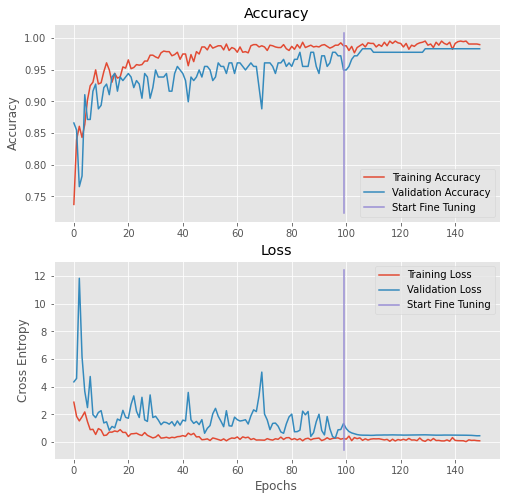

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.6301 - accuracy: 0.9375

2/5 [===========>..................] - ETA: 2s - loss: 1.8037 - accuracy: 0.9453

3/5 [=================>............] - ETA: 2s - loss: 1.2870 - accuracy: 0.9609

4/5 [=======================>......] - ETA: 1s - loss: 1.1751 - accuracy: 0.9688

5/5 [==============================] - ETA: 0s - loss: 1.1163 - accuracy: 0.9703

5/5 [==============================] - 6s 1s/step - loss: 1.1163 - accuracy: 0.9703


[1.1162749528884888, 0.9703153967857361]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9703153988868275
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.96       539
weighted avg       0.97      0.97      0.97       539



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

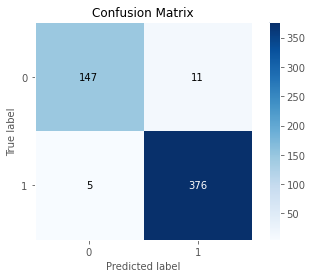

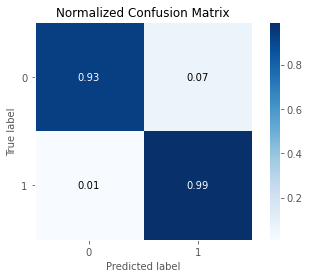

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

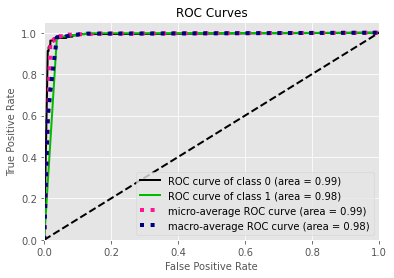

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       158
           1       0.97      0.99      0.98       381

    accuracy                           0.97       539
   macro avg       0.97      0.96      0.96       539
weighted avg       0.97      0.97      0.97       539

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.93      0.99      0.95      0.96      0.91       158
          1       0.97      0.99      0.93      0.98      0.96      0.92       381

avg / total       0.97      0.97      0.95      0.97      0.96      0.92       539

